=== DATA ANALYST SKILLS ANALYSIS FROM POSTGRESQL ===

Connecting to PostgreSQL database...
Host: localhost:5432
Database: sql_course
User: postgres
‚úÖ Database connection successful!
Executing SQL query...
‚úÖ Successfully loaded 37 rows from database

Total skills analyzed: 36
Salary range: $81,634 - $115,320
Demand range: 11 - 398 job postings

=== SUMMARY STATISTICS ===
       demand_count     avg_salary
count     36.000000      36.000000
mean      59.694444   99685.527778
std       86.848906    8782.630873
min       11.000000   81634.000000
25%       15.500000   96436.250000
50%       25.500000   99229.500000
75%       48.250000  105359.250000
max      398.000000  115320.000000


=== KEY INSIGHTS ===
Top 3 Highest Paying Skills:
  ‚Ä¢ Go: $115,320 (27 jobs)
  ‚Ä¢ Confluence: $114,210 (11 jobs)
  ‚Ä¢ Hadoop: $113,193 (22 jobs)

Top 3 Most In-Demand Skills:
  ‚Ä¢ Sql: 398 jobs ($97,237)
  ‚Ä¢ Excel: 256 jobs ($87,288)
  ‚Ä¢ Python: 236 jobs ($101,397)




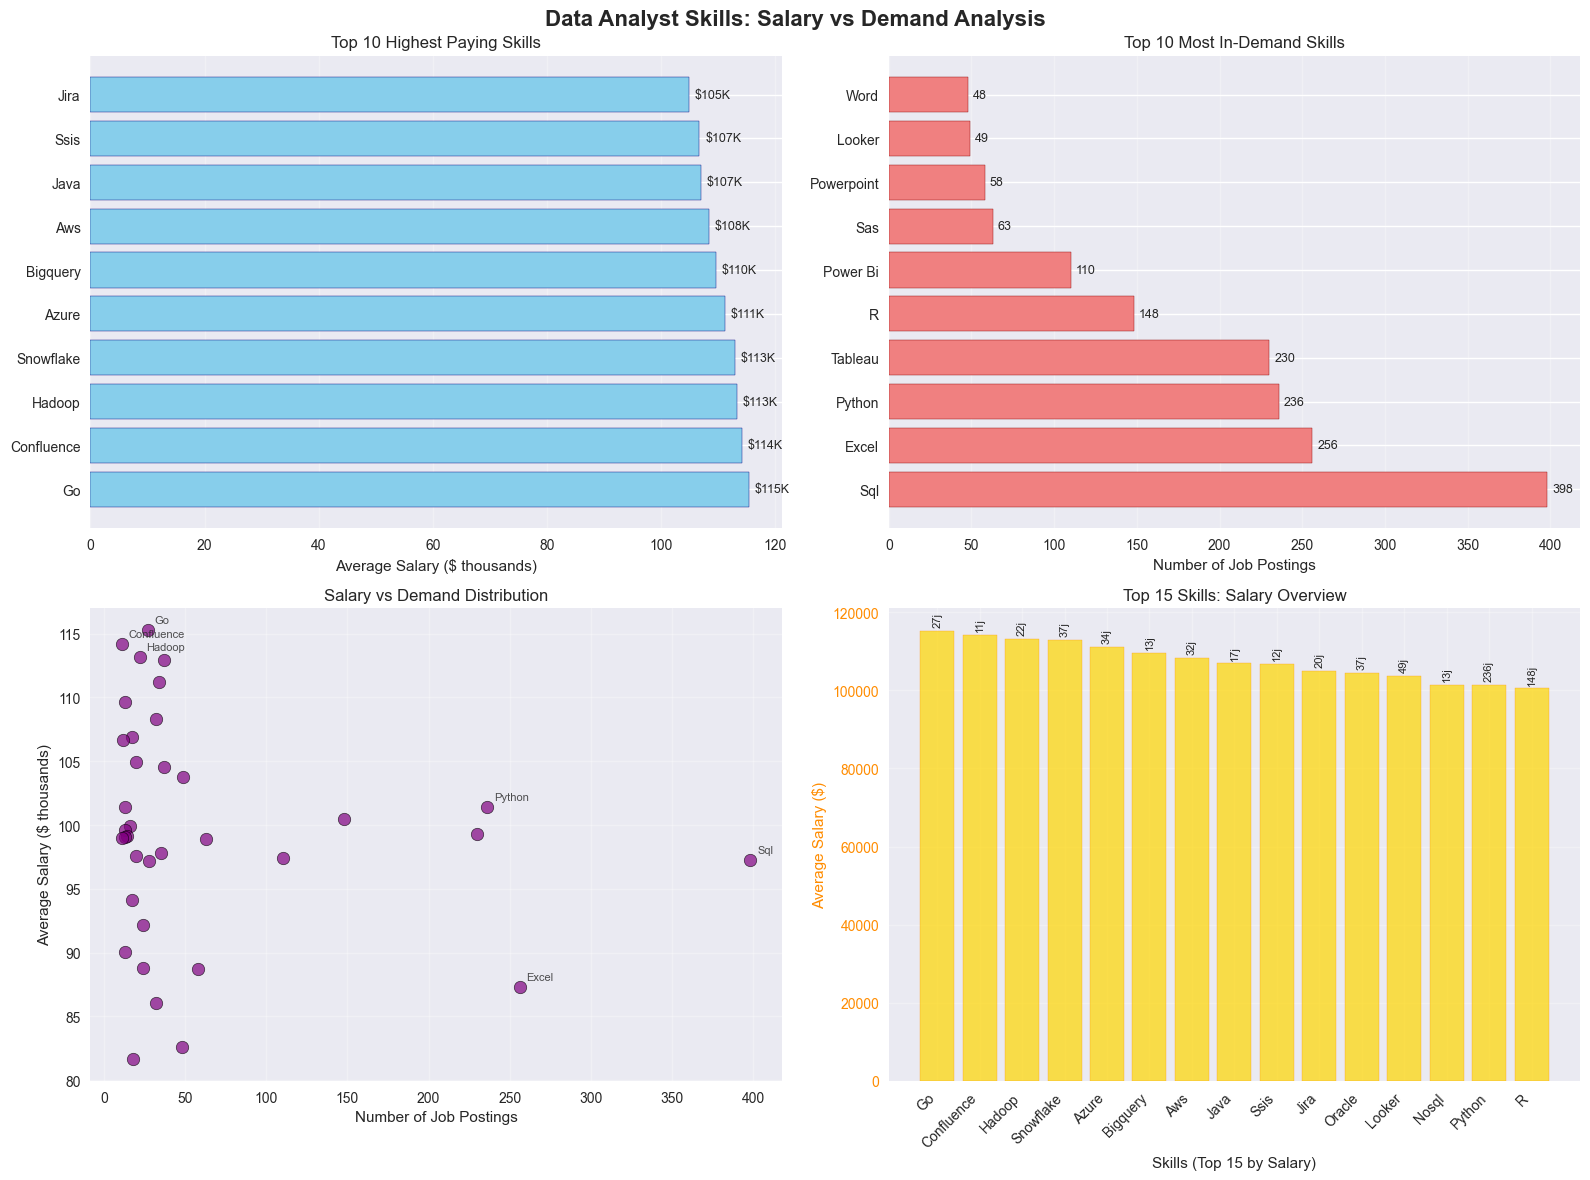

=== SKILL CATEGORY ANALYSIS ===

Skill Categories Ranked by Average Salary:
                       Avg_Salary  Total_Demand  Skill_Count
category                                                    
Cloud Platforms         110830.00           103            3
Collaboration Tools     109564.00            31            2
Databases               104419.50           136            6
Programming Languages   103444.50           459            6
Analytics Tools         100958.25           102            4
Visualization Tools     100904.67           292            3
Other                    90277.50          1026           12


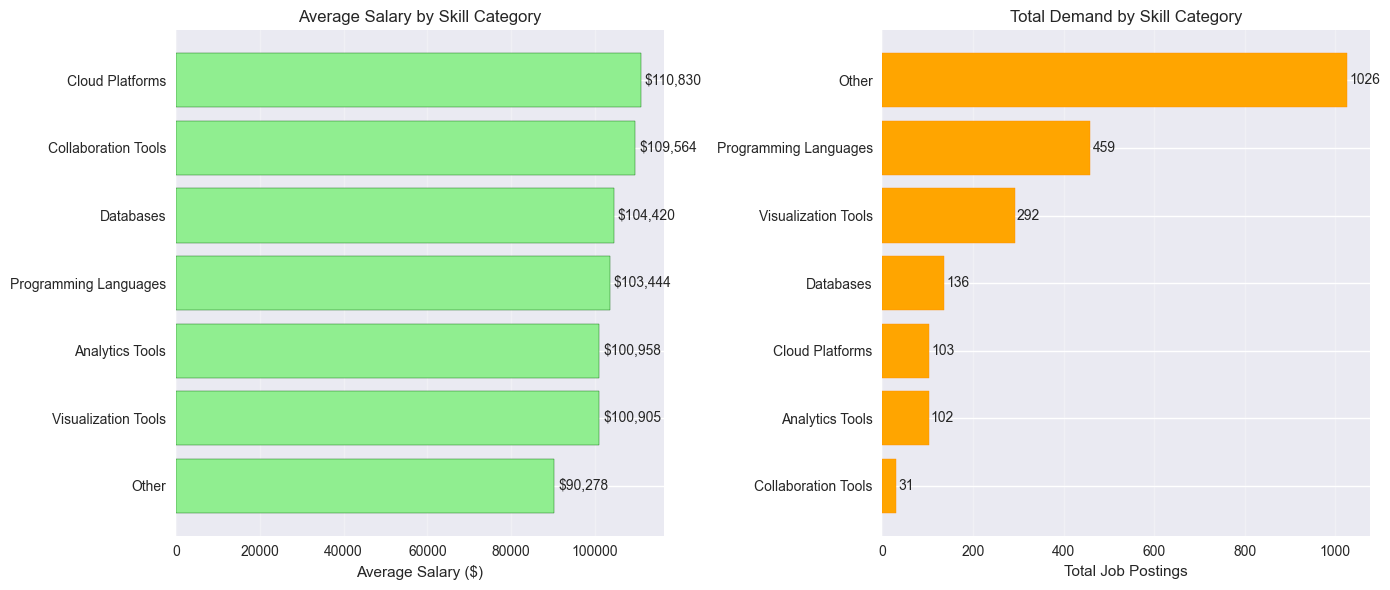

‚úÖ Analysis complete! 36 skills analyzed across 7 categories.
=== TOP 5 MOST IN-DEMAND DATA ANALYST SKILLS ===



TypeError: 'NoneType' object is not subscriptable

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import psycopg2
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# =============================================================================
# POSTGRESQL DATABASE CONNECTION
# =============================================================================

def load_data_from_postgresql():
    """
    Load data using the SQL query from PostgreSQL database.
    """
    
    # Your original SQL query
    sql_query = """
    SELECT
        skills_dim.skill_id,
        skills_dim.skills,
        COUNT(skills_job_dim.job_id) AS demand_count,
        ROUND(AVG(job_postings_fact.salary_year_avg),0) AS avg_salary
    FROM
        job_postings_fact
    INNER JOIN skills_job_dim ON job_postings_fact.job_id = skills_job_dim.job_id
    INNER JOIN skills_dim ON skills_job_dim.skill_id = skills_dim.skill_id
    WHERE
        job_title_short = 'Data Analyst'
        AND salary_year_avg IS NOT NULL
        AND job_work_from_home = TRUE
    GROUP BY
        skills_dim.skill_id
    HAVING
        COUNT(skills_job_dim.job_id) > 10
    ORDER BY
        avg_salary DESC,
        demand_count DESC
    """
    
    # Database connection parameters
    DB_CONFIG = {
        'host': 'localhost',
        'port': 5432,
        'database': 'sql_course',
        'username': 'postgres',
        'password': 'fauzanrmds'
    }
    
    # Create connection string
    CONNECTION_STRING = f"postgresql://{DB_CONFIG['username']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
    
    print("Connecting to PostgreSQL database...")
    print(f"Host: {DB_CONFIG['host']}:{DB_CONFIG['port']}")
    print(f"Database: {DB_CONFIG['database']}")
    print(f"User: {DB_CONFIG['username']}")
    
    try:
        # Create database engine
        engine = create_engine(CONNECTION_STRING)
        
        # Test connection
        with engine.connect() as conn:
            print("‚úÖ Database connection successful!")
        
        # Execute query and load into DataFrame
        print("Executing SQL query...")
        df = pd.read_sql_query(sql_query, engine)
        
        if df.empty:
            raise ValueError("Query returned no results. Check your data and query conditions.")
        
        print(f"‚úÖ Successfully loaded {len(df)} rows from database")
        return df
        
    except Exception as e:
        print(f"‚ùå Database operation failed: {str(e)}")
        print("\nüí° Troubleshooting tips:")
        print("1. Check if PostgreSQL is running")
        print("2. Verify database name, username, and password")
        print("3. Ensure the required tables exist: job_postings_fact, skills_job_dim, skills_dim")
        print("4. Check if your user has SELECT permissions on these tables")
        raise

# =============================================================================
# LOAD AND ANALYZE DATA
# =============================================================================

print("=== DATA ANALYST SKILLS ANALYSIS FROM POSTGRESQL ===\n")

# Load data from PostgreSQL database
df = load_data_from_postgresql()

# Data preprocessing
df['salary_k'] = df['avg_salary'] / 1000  # Convert to thousands for readability
df['skills'] = df['skills'].str.title()  # Capitalize for better presentation

# Remove any potential duplicate entries
df = df.drop_duplicates(subset=['skills'], keep='first')

print(f"\nTotal skills analyzed: {len(df)}")
print(f"Salary range: ${df['avg_salary'].min():,.0f} - ${df['avg_salary'].max():,.0f}")
print(f"Demand range: {df['demand_count'].min()} - {df['demand_count'].max()} job postings\n")

# Basic statistics
print("=== SUMMARY STATISTICS ===")
print(df[['demand_count', 'avg_salary']].describe())
print("\n")

# Top insights
print("=== KEY INSIGHTS ===")
top_salary = df.nlargest(3, 'avg_salary')
top_demand = df.nlargest(3, 'demand_count')

print("Top 3 Highest Paying Skills:")
for _, row in top_salary.iterrows():
    print(f"  ‚Ä¢ {row['skills']}: ${row['avg_salary']:,.0f} ({row['demand_count']} jobs)")

print("\nTop 3 Most In-Demand Skills:")
for _, row in top_demand.iterrows():
    print(f"  ‚Ä¢ {row['skills']}: {row['demand_count']} jobs (${row['avg_salary']:,.0f})")

print("\n" + "="*60 + "\n")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Data Analyst Skills: Salary vs Demand Analysis', fontsize=16, fontweight='bold')

# 1. Top 10 Highest Paying Skills
top_10_salary = df.nlargest(10, 'avg_salary')
ax1 = axes[0, 0]
bars1 = ax1.barh(top_10_salary['skills'], top_10_salary['salary_k'], color='skyblue', edgecolor='navy')
ax1.set_xlabel('Average Salary ($ thousands)')
ax1.set_title('Top 10 Highest Paying Skills')
ax1.grid(axis='x', alpha=0.3)

for i, (bar, salary) in enumerate(zip(bars1, top_10_salary['avg_salary'])):
    ax1.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
             f'${salary/1000:.0f}K', va='center', fontsize=9)

# 2. Top 10 Most Demanded Skills
top_10_demand = df.nlargest(10, 'demand_count')
ax2 = axes[0, 1]
bars2 = ax2.barh(top_10_demand['skills'], top_10_demand['demand_count'], color='lightcoral', edgecolor='darkred')
ax2.set_xlabel('Number of Job Postings')
ax2.set_title('Top 10 Most In-Demand Skills')
ax2.grid(axis='x', alpha=0.3)

for i, (bar, demand) in enumerate(zip(bars2, top_10_demand['demand_count'])):
    ax2.text(bar.get_width() + 3, bar.get_y() + bar.get_height()/2, 
             f'{demand}', va='center', fontsize=9)

# 3. Scatter Plot: Salary vs Demand
ax3 = axes[1, 0]
scatter = ax3.scatter(df['demand_count'], df['salary_k'], 
                     s=80, alpha=0.7, c='purple', edgecolors='black', linewidth=0.5)

ax3.set_xlabel('Number of Job Postings')
ax3.set_ylabel('Average Salary ($ thousands)')
ax3.set_title('Salary vs Demand Distribution')
ax3.grid(alpha=0.3)

# Add labels for top skills by salary and demand
top_salary_skills = df.nlargest(3, 'avg_salary')
top_demand_skills = df.nlargest(3, 'demand_count')
combined_top = pd.concat([top_salary_skills, top_demand_skills]).drop_duplicates()

for _, row in combined_top.iterrows():
    ax3.annotate(row['skills'], 
                (row['demand_count'], row['salary_k']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, alpha=0.8)

# 4. Salary vs Demand Comparison
ax4 = axes[1, 1]

# Create a dual-axis comparison chart
x_pos = range(len(df.head(15)))  # Top 15 skills
top_15_skills = df.nlargest(15, 'avg_salary')

bars4 = ax4.bar(x_pos, top_15_skills['avg_salary'], alpha=0.7, color='gold', edgecolor='darkorange', label='Salary')
ax4.set_xlabel('Skills (Top 15 by Salary)')
ax4.set_ylabel('Average Salary ($)', color='darkorange')
ax4.tick_params(axis='y', labelcolor='darkorange')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(top_15_skills['skills'], rotation=45, ha='right')
ax4.set_title('Top 15 Skills: Salary Overview')
ax4.grid(alpha=0.3)

# Add demand as text annotations
for i, (bar, demand) in enumerate(zip(bars4, top_15_skills['demand_count'])):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000, 
             f'{demand}j', ha='center', va='bottom', fontsize=8, rotation=90)

plt.tight_layout()
plt.show()

# Skill Categories Analysis
print("=== SKILL CATEGORY ANALYSIS ===")

skill_categories = {
    'Programming Languages': ['Python', 'R', 'Java', 'Javascript', 'Go', 'C++'],
    'Cloud Platforms': ['Aws', 'Azure', 'Snowflake'],
    'Databases': ['Sql Server', 'Oracle', 'Redshift', 'Bigquery', 'Hadoop', 'Nosql'],
    'Visualization Tools': ['Tableau', 'Looker', 'Qlik'],
    'Analytics Tools': ['Sas', 'Spark', 'Ssis', 'Ssrs'],
    'Collaboration Tools': ['Jira', 'Confluence']
}

def get_category(skill):
    for category, skills in skill_categories.items():
        if skill in skills:
            return category
    return 'Other'

df['category'] = df['skills'].apply(get_category)

category_stats = df.groupby('category').agg({
    'avg_salary': 'mean',
    'demand_count': 'sum',
    'skills': 'count'
}).round(2)

category_stats.columns = ['Avg_Salary', 'Total_Demand', 'Skill_Count']
category_stats = category_stats.sort_values('Avg_Salary', ascending=False)

print("\nSkill Categories Ranked by Average Salary:")
print(category_stats)

# Category visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

category_stats_sorted = category_stats.sort_values('Avg_Salary', ascending=True)
bars1 = ax1.barh(category_stats_sorted.index, category_stats_sorted['Avg_Salary'], 
                color='lightgreen', edgecolor='darkgreen')
ax1.set_xlabel('Average Salary ($)')
ax1.set_title('Average Salary by Skill Category')
ax1.grid(axis='x', alpha=0.3)

for bar, salary in zip(bars1, category_stats_sorted['Avg_Salary']):
    ax1.text(bar.get_width() + 1000, bar.get_y() + bar.get_height()/2, 
             f'${salary:,.0f}', va='center', fontsize=10)

category_demand_sorted = category_stats.sort_values('Total_Demand', ascending=True)
bars2 = ax2.barh(category_demand_sorted.index, category_demand_sorted['Total_Demand'], 
                color='orange', edgecolor='darkorange')
ax2.set_xlabel('Total Job Postings')
ax2.set_title('Total Demand by Skill Category')
ax2.grid(axis='x', alpha=0.3)

for bar, demand in zip(bars2, category_demand_sorted['Total_Demand']):
    ax2.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, 
             f'{demand:.0f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print(f"‚úÖ Analysis complete! {len(df)} skills analyzed across {len(df['category'].unique())} categories.")


=== TOP 5 MOST IN-DEMAND DATA ANALYST SKILLS ===

Connecting to PostgreSQL database...
Host: localhost:5432
Database: sql_course
User: postgres
‚úÖ Database connection successful!
Executing SQL query...
‚úÖ Successfully loaded 5 skills from database
Analysis Focus: Remote Data Analyst positions
Total demand range: 2609 - 7291 job postings

=== TOP 5 MOST IN-DEMAND SKILLS ===
1. Sql: 7291 job postings
2. Excel: 4611 job postings
3. Python: 4330 job postings
4. Tableau: 3745 job postings
5. Power Bi: 2609 job postings


=== MARKET SHARE ANALYSIS ===
‚Ä¢ Sql: 32.3% of top 5 skills demand
‚Ä¢ Excel: 20.4% of top 5 skills demand
‚Ä¢ Python: 19.2% of top 5 skills demand
‚Ä¢ Tableau: 16.6% of top 5 skills demand
‚Ä¢ Power Bi: 11.6% of top 5 skills demand

Total job postings (top 5 skills): 22586




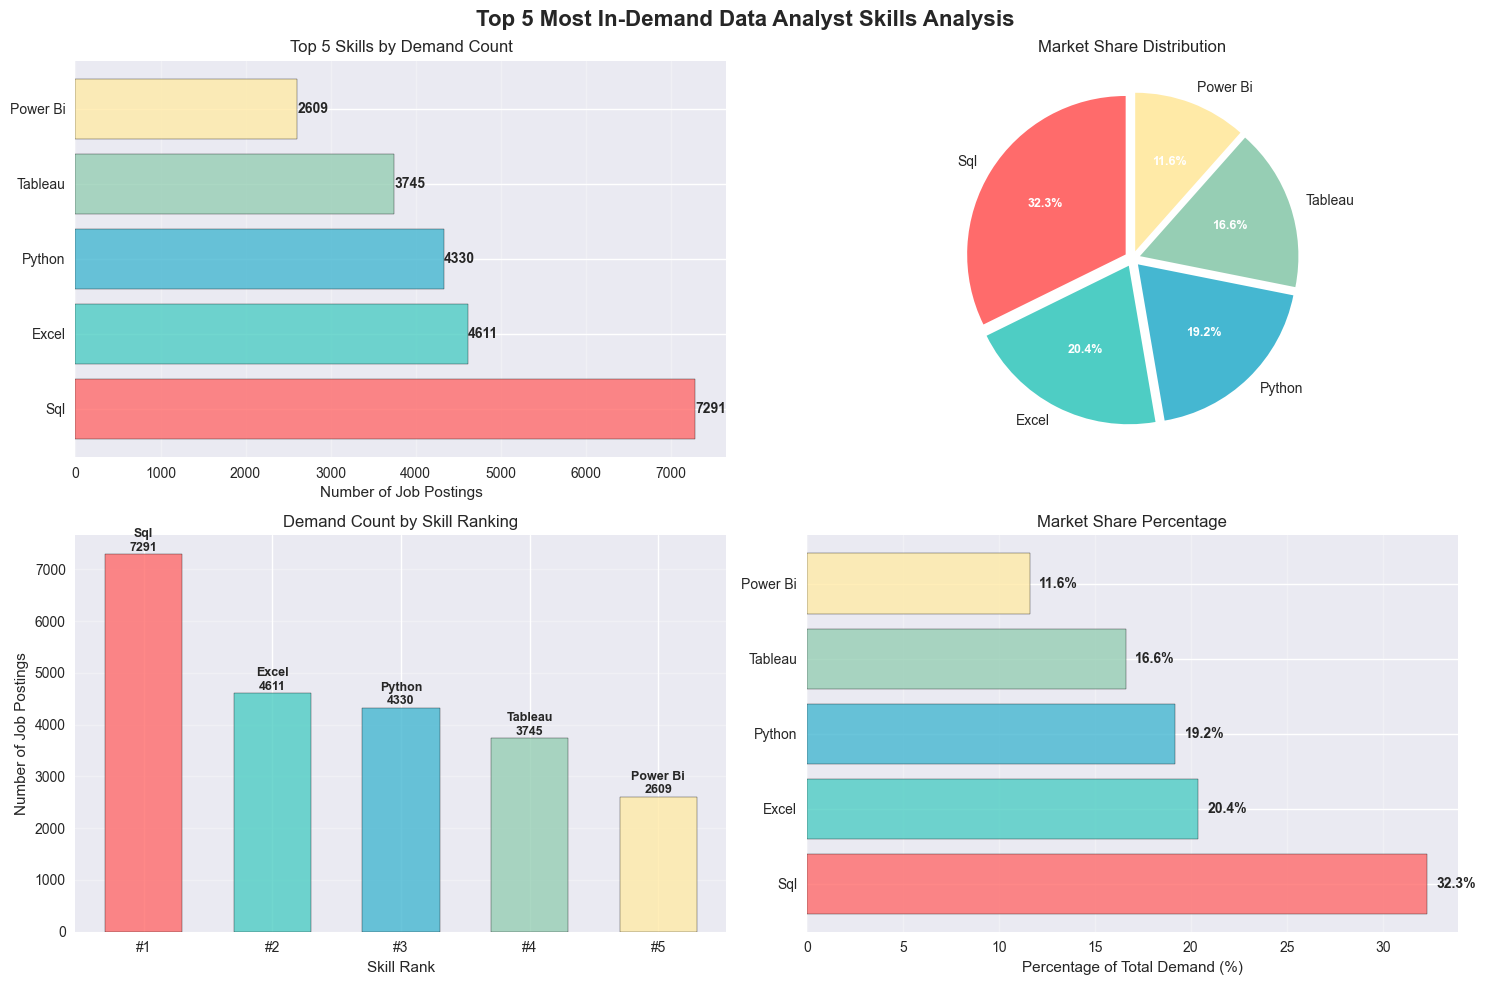

=== DETAILED INSIGHTS ===
üìä Skill Demand Gaps:
  ‚Ä¢ Sql vs Excel: 2680 jobs difference (36.8% gap)
  ‚Ä¢ Excel vs Python: 281 jobs difference (6.1% gap)
  ‚Ä¢ Python vs Tableau: 585 jobs difference (13.5% gap)
  ‚Ä¢ Tableau vs Power Bi: 1136 jobs difference (30.3% gap)

üèÜ Market Leader: Sql dominates with 7291 job postings

üìã Skill Categories:
  ‚Ä¢ Sql: Database Management
  ‚Ä¢ Excel: Spreadsheet Analysis
  ‚Ä¢ Python: Programming Language
  ‚Ä¢ Tableau: Data Visualization
  ‚Ä¢ Power Bi: Business Intelligence

‚úÖ Results exported to 'top_5_demand_skills_analysis.csv'
‚úÖ Analysis complete! Top 5 most in-demand skills identified for remote Data Analyst positions.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import psycopg2
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# =============================================================================
# POSTGRESQL DATABASE CONNECTION
# =============================================================================

def load_top_5_demand_skills():
    """
    Load top 5 most in-demand skills for data analysts using SQL query.
    """
    
    # Your SQL query for top 5 most in-demand skills
    sql_query = """
    SELECT
        skills,
        COUNT(skills_job_dim.job_id) AS demand_count
    FROM
        job_postings_fact
    INNER JOIN
        skills_job_dim ON job_postings_fact.job_id = skills_job_dim.job_id
    INNER JOIN
        skills_dim ON skills_job_dim.skill_id = skills_dim.skill_id
    WHERE
        job_title_short = 'Data Analyst' AND
        job_work_from_home = TRUE
    GROUP BY
        skills
    ORDER BY   
        demand_count DESC
    LIMIT 5
    """
    
    # Database connection parameters
    DB_CONFIG = {
        'host': 'localhost',
        'port': 5432,
        'database': 'sql_course',
        'username': 'postgres',
        'password': 'fauzanrmds'
    }
    
    # Create connection string
    CONNECTION_STRING = f"postgresql://{DB_CONFIG['username']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
    
    print("Connecting to PostgreSQL database...")
    print(f"Host: {DB_CONFIG['host']}:{DB_CONFIG['port']}")
    print(f"Database: {DB_CONFIG['database']}")
    print(f"User: {DB_CONFIG['username']}")
    
    try:
        # Create database engine
        engine = create_engine(CONNECTION_STRING)
        
        # Test connection
        with engine.connect() as conn:
            print("‚úÖ Database connection successful!")
        
        # Execute query and load into DataFrame
        print("Executing SQL query...")
        df = pd.read_sql_query(sql_query, engine)
        
        if df.empty:
            raise ValueError("Query returned no results. Check your data and query conditions.")
        
        print(f"‚úÖ Successfully loaded {len(df)} skills from database")
        return df
        
    except Exception as e:
        print(f"‚ùå Database operation failed: {str(e)}")
        print("\nüí° Troubleshooting tips:")
        print("1. Check if PostgreSQL is running")
        print("2. Verify database name, username, and password")
        print("3. Ensure the required tables exist: job_postings_fact, skills_job_dim, skills_dim")
        print("4. Check if your user has SELECT permissions on these tables")
        raise

# =============================================================================
# LOAD AND ANALYZE DATA
# =============================================================================

print("=== TOP 5 MOST IN-DEMAND DATA ANALYST SKILLS ===\n")

# Load data from PostgreSQL database
df = load_top_5_demand_skills()

# Data preprocessing
df['skills'] = df['skills'].str.title()  # Capitalize for better presentation

print(f"Analysis Focus: Remote Data Analyst positions")
print(f"Total demand range: {df['demand_count'].min()} - {df['demand_count'].max()} job postings\n")

# Display the top 5 skills
print("=== TOP 5 MOST IN-DEMAND SKILLS ===")
for i, (_, row) in enumerate(df.iterrows(), 1):
    print(f"{i}. {row['skills']}: {row['demand_count']} job postings")

print("\n" + "="*50 + "\n")

# Calculate percentages
total_postings = df['demand_count'].sum()
df['percentage'] = (df['demand_count'] / total_postings * 100).round(1)

print("=== MARKET SHARE ANALYSIS ===")
for _, row in df.iterrows():
    print(f"‚Ä¢ {row['skills']}: {row['percentage']}% of top 5 skills demand")

print(f"\nTotal job postings (top 5 skills): {total_postings}")
print("\n" + "="*50 + "\n")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Top 5 Most In-Demand Data Analyst Skills Analysis', fontsize=16, fontweight='bold')

# 1. Horizontal Bar Chart
ax1 = axes[0, 0]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
bars1 = ax1.barh(df['skills'], df['demand_count'], color=colors, edgecolor='black', alpha=0.8)
ax1.set_xlabel('Number of Job Postings')
ax1.set_title('Top 5 Skills by Demand Count')
ax1.grid(axis='x', alpha=0.3)

# Add value labels on bars
for bar, count in zip(bars1, df['demand_count']):
    ax1.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, 
             f'{count}', va='center', fontweight='bold', fontsize=10)

# 2. Pie Chart
ax2 = axes[0, 1]
wedges, texts, autotexts = ax2.pie(df['demand_count'], labels=df['skills'], autopct='%1.1f%%', 
                                   colors=colors, startangle=90, explode=(0.05, 0.05, 0.05, 0.05, 0.05))
ax2.set_title('Market Share Distribution')

# Enhance pie chart text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(9)

# 3. Vertical Bar Chart with Trend
ax3 = axes[1, 0]
bars3 = ax3.bar(range(len(df)), df['demand_count'], color=colors, edgecolor='black', alpha=0.8, width=0.6)
ax3.set_xlabel('Skill Rank')
ax3.set_ylabel('Number of Job Postings')
ax3.set_title('Demand Count by Skill Ranking')
ax3.set_xticks(range(len(df)))
ax3.set_xticklabels([f"#{i+1}" for i in range(len(df))])
ax3.grid(axis='y', alpha=0.3)

# Add skill names as labels
for i, (bar, skill, count) in enumerate(zip(bars3, df['skills'], df['demand_count'])):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             f'{skill}\n{count}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 4. Comparison Chart with Percentages
ax4 = axes[1, 1]
y_pos = np.arange(len(df))
bars4 = ax4.barh(y_pos, df['percentage'], color=colors, edgecolor='black', alpha=0.8)
ax4.set_yticks(y_pos)
ax4.set_yticklabels(df['skills'])
ax4.set_xlabel('Percentage of Total Demand (%)')
ax4.set_title('Market Share Percentage')
ax4.grid(axis='x', alpha=0.3)

# Add percentage labels
for i, (bar, percentage) in enumerate(zip(bars4, df['percentage'])):
    ax4.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{percentage}%', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# Additional Analysis
print("=== DETAILED INSIGHTS ===")

# Calculate gaps between skills
df_sorted = df.sort_values('demand_count', ascending=False).reset_index(drop=True)
print(f"üìä Skill Demand Gaps:")
for i in range(len(df_sorted)-1):
    current_skill = df_sorted.loc[i, 'skills']
    next_skill = df_sorted.loc[i+1, 'skills']
    current_count = df_sorted.loc[i, 'demand_count']
    next_count = df_sorted.loc[i+1, 'demand_count']
    gap = current_count - next_count
    gap_percentage = (gap / current_count * 100)
    print(f"  ‚Ä¢ {current_skill} vs {next_skill}: {gap} jobs difference ({gap_percentage:.1f}% gap)")

print(f"\nüèÜ Market Leader: {df_sorted.loc[0, 'skills']} dominates with {df_sorted.loc[0, 'demand_count']} job postings")

# Skill categories
skill_categories = {
    'Sql': 'Database Management',
    'Excel': 'Spreadsheet Analysis',
    'Python': 'Programming Language',
    'Tableau': 'Data Visualization',
    'Power Bi': 'Business Intelligence',
    'R': 'Statistical Programming'
}

print(f"\nüìã Skill Categories:")
for _, row in df.iterrows():
    category = skill_categories.get(row['skills'], 'Other')
    print(f"  ‚Ä¢ {row['skills']}: {category}")

# Create a summary DataFrame for export
summary_df = df.copy()
summary_df['rank'] = range(1, len(summary_df) + 1)
summary_df['category'] = summary_df['skills'].map(skill_categories)
summary_df = summary_df[['rank', 'skills', 'demand_count', 'percentage', 'category']]

print(f"‚úÖ Analysis complete! Top 5 most in-demand skills identified for remote Data Analyst positions.")

=== TOP PAYING DATA ANALYST JOBS ANALYSIS ===

Connecting to PostgreSQL database...
Host: localhost:5432
Database: sql_course
User: postgres
‚úÖ Database connection successful!
Executing SQL query...
‚úÖ Successfully loaded 66 job-skill combinations from database
Analysis Focus: Remote Data Analyst positions with salary information
Salary range: $184,000 - $255,830

=== TOP 10 HIGHEST PAYING DATA ANALYST JOBS ===
1. Associate Director- Data Insights at AT&T: $255,830
2. Data Analyst, Marketing at Pinterest Job Advertisements: $232,423
3. Data Analyst (Hybrid/Remote) at Uclahealthcareers: $217,000
4. Principal Data Analyst (Remote) at SmartAsset: $205,000
5. Director, Data Analyst - HYBRID at Inclusively: $189,309
6. Principal Data Analyst, AV Performance Analysis at Motional: $189,000
7. Principal Data Analyst at SmartAsset: $186,000
8. ERM Data Analyst at Get It Recruit - Information Technology: $184,000


=== MOST DEMANDED SKILLS IN TOP PAYING JOBS ===
1. Sql: 8 jobs, Avg: $207,320, 

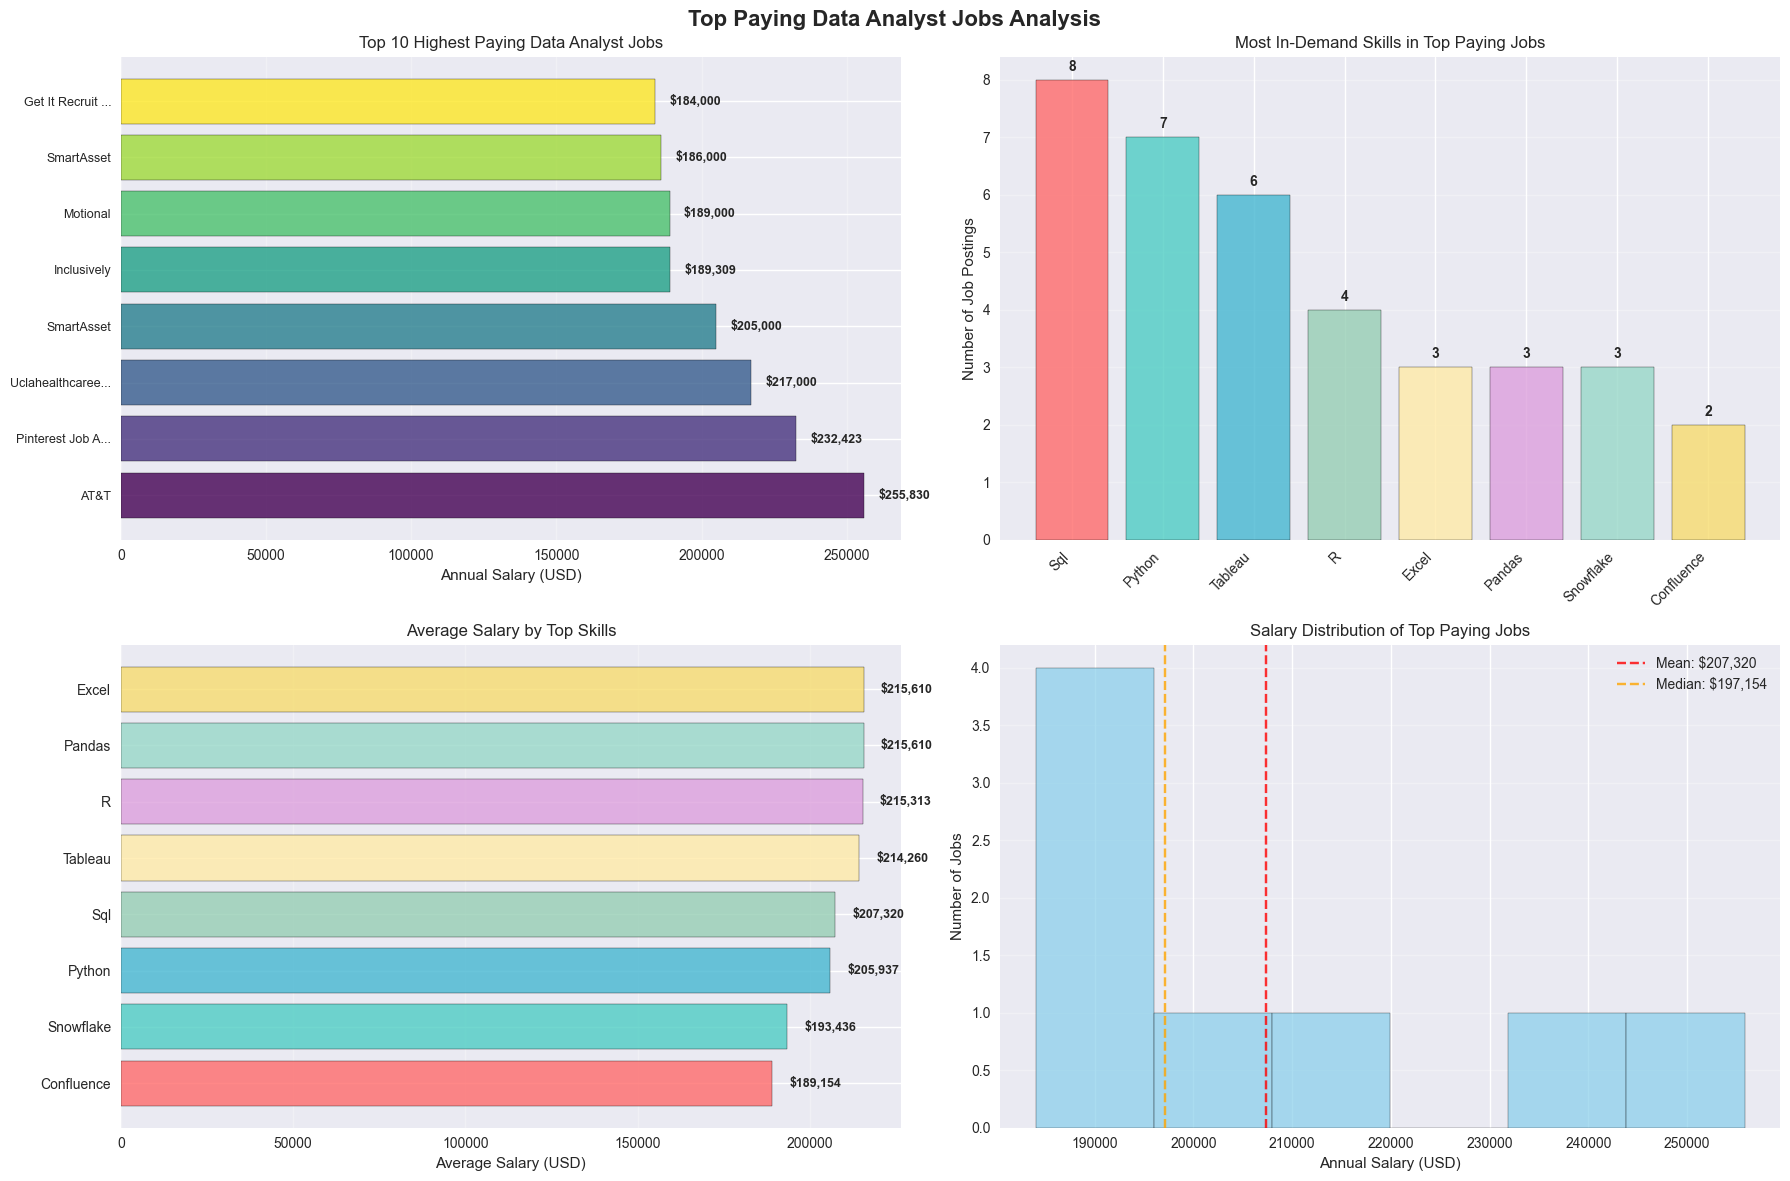

=== DETAILED INSIGHTS ===
üí∞ Salary Statistics:
  ‚Ä¢ Highest Salary: $255,830
  ‚Ä¢ Lowest Salary: $184,000
  ‚Ä¢ Average Salary: $207,320
  ‚Ä¢ Median Salary: $197,154
  ‚Ä¢ Salary Range: $71,830

üìà Skills Premium Analysis (Top 5 Skills):
  ‚Ä¢ Sql: -0.0% vs average salary
  ‚Ä¢ Python: -0.7% vs average salary
  ‚Ä¢ Tableau: +3.3% vs average salary
  ‚Ä¢ R: +3.9% vs average salary
  ‚Ä¢ Excel: +4.0% vs average salary

üè¢ Top Paying Companies:
  ‚Ä¢ AT&T: Max $255,830, Avg $255,830 (1 jobs)
  ‚Ä¢ Pinterest Job Advertisements: Max $232,423, Avg $232,423 (1 jobs)
  ‚Ä¢ Uclahealthcareers: Max $217,000, Avg $217,000 (1 jobs)
  ‚Ä¢ SmartAsset: Max $205,000, Avg $195,500 (2 jobs)
  ‚Ä¢ Inclusively: Max $189,309, Avg $189,309 (1 jobs)

üìã Skill Categories in Top Jobs:
  ‚Ä¢ Database Management: Sql
  ‚Ä¢ Programming Language: Python
  ‚Ä¢ Data Visualization: Tableau
  ‚Ä¢ Statistical Programming: R
  ‚Ä¢ Spreadsheet Analysis: Excel
  ‚Ä¢ Other: Pandas, Confluence, Bitbucket, Atlassi

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import psycopg2
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# =============================================================================
# POSTGRESQL DATABASE CONNECTION
# =============================================================================

def load_top_paying_jobs():
    """
    Load top paying Data Analyst jobs and their required skills using SQL query.
    """
    
    # Your SQL query for top paying jobs with skills
    sql_query = """
    WITH top_paying_jobs AS (
        SELECT 
            job_id, 
            job_title, 
            salary_year_avg, 
            name AS company_name 
        FROM 
            job_postings_fact 
        LEFT JOIN 
            company_dim ON job_postings_fact.company_id = company_dim.company_id 
        WHERE 
            job_title_short = 'Data Analyst' AND 
            job_location = 'Anywhere' AND 
            salary_year_avg IS NOT NULL 
        ORDER BY 
            salary_year_avg DESC 
        LIMIT 10
    ) 
    SELECT 
        top_paying_jobs.*, 
        skills 
    FROM 
        top_paying_jobs 
    INNER JOIN 
        skills_job_dim ON top_paying_jobs.job_id = skills_job_dim.job_id 
    INNER JOIN 
        skills_dim ON skills_job_dim.skill_id = skills_dim.skill_id 
    ORDER BY 
        salary_year_avg DESC
    """
    
    # Database connection parameters
    DB_CONFIG = {
        'host': 'localhost',
        'port': 5432,
        'database': 'sql_course',
        'username': 'postgres',
        'password': 'fauzanrmds'
    }
    
    # Create connection string
    CONNECTION_STRING = f"postgresql://{DB_CONFIG['username']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
    
    print("Connecting to PostgreSQL database...")
    print(f"Host: {DB_CONFIG['host']}:{DB_CONFIG['port']}")
    print(f"Database: {DB_CONFIG['database']}")
    print(f"User: {DB_CONFIG['username']}")
    
    try:
        # Create database engine
        engine = create_engine(CONNECTION_STRING)
        
        # Test connection
        with engine.connect() as conn:
            print("‚úÖ Database connection successful!")
        
        # Execute query and load into DataFrame
        print("Executing SQL query...")
        df = pd.read_sql_query(sql_query, engine)
        
        if df.empty:
            raise ValueError("Query returned no results. Check your data and query conditions.")
        
        print(f"‚úÖ Successfully loaded {len(df)} job-skill combinations from database")
        return df
        
    except Exception as e:
        print(f"‚ùå Database operation failed: {str(e)}")
        print("\nüí° Troubleshooting tips:")
        print("1. Check if PostgreSQL is running")
        print("2. Verify database name, username, and password")
        print("3. Ensure the required tables exist: job_postings_fact, skills_job_dim, skills_dim, company_dim")
        print("4. Check if your user has SELECT permissions on these tables")
        raise

# =============================================================================
# LOAD AND ANALYZE DATA
# =============================================================================

print("=== TOP PAYING DATA ANALYST JOBS ANALYSIS ===\n")

# Load data from PostgreSQL database
df = load_top_paying_jobs()

# Data preprocessing
df['skills'] = df['skills'].str.title()  # Capitalize for better presentation
df['salary_year_avg'] = df['salary_year_avg'].astype(float)
df['salary_formatted'] = df['salary_year_avg'].apply(lambda x: f"${x:,.0f}")

print(f"Analysis Focus: Remote Data Analyst positions with salary information")
print(f"Salary range: ${df['salary_year_avg'].min():,.0f} - ${df['salary_year_avg'].max():,.0f}\n")

# Get unique jobs for job analysis
jobs_df = df.drop_duplicates(subset=['job_id']).sort_values('salary_year_avg', ascending=False).reset_index(drop=True)

print("=== TOP 10 HIGHEST PAYING DATA ANALYST JOBS ===")
for i, (_, row) in enumerate(jobs_df.iterrows(), 1):
    print(f"{i}. {row['job_title']} at {row['company_name']}: ${row['salary_year_avg']:,.0f}")

print("\n" + "="*70 + "\n")

# Skills analysis
skills_analysis = df.groupby('skills').agg({
    'job_id': 'nunique',
    'salary_year_avg': ['mean', 'median', 'max']
}).round(0)

skills_analysis.columns = ['job_count', 'avg_salary', 'median_salary', 'max_salary']
skills_analysis = skills_analysis.sort_values('job_count', ascending=False)

print("=== MOST DEMANDED SKILLS IN TOP PAYING JOBS ===")
for i, (skill, row) in enumerate(skills_analysis.head(10).iterrows(), 1):
    print(f"{i}. {skill}: {int(row['job_count'])} jobs, Avg: ${int(row['avg_salary']):,}, Max: ${int(row['max_salary']):,}")

print("\n" + "="*70 + "\n")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Top Paying Data Analyst Jobs Analysis', fontsize=16, fontweight='bold')

# 1. Top 10 Jobs by Salary
ax1 = axes[0, 0]
colors1 = plt.cm.viridis(np.linspace(0, 1, len(jobs_df)))
bars1 = ax1.barh(range(len(jobs_df)), jobs_df['salary_year_avg'], color=colors1, edgecolor='black', alpha=0.8)
ax1.set_yticks(range(len(jobs_df)))
ax1.set_yticklabels([f"{row['company_name'][:15]}..." if len(row['company_name']) > 15 else row['company_name'] 
                     for _, row in jobs_df.iterrows()], fontsize=9)
ax1.set_xlabel('Annual Salary (USD)')
ax1.set_title('Top 10 Highest Paying Data Analyst Jobs')
ax1.grid(axis='x', alpha=0.3)

# Add salary labels
for i, (bar, salary) in enumerate(zip(bars1, jobs_df['salary_year_avg'])):
    ax1.text(bar.get_width() + 5000, bar.get_y() + bar.get_height()/2, 
             f'${salary:,.0f}', va='center', fontweight='bold', fontsize=9)

# 2. Skills Frequency in Top Jobs
ax2 = axes[0, 1]
top_skills = skills_analysis.head(8)
colors2 = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8', '#F7DC6F']
bars2 = ax2.bar(range(len(top_skills)), top_skills['job_count'], color=colors2, edgecolor='black', alpha=0.8)
ax2.set_xticks(range(len(top_skills)))
ax2.set_xticklabels(top_skills.index, rotation=45, ha='right')
ax2.set_ylabel('Number of Job Postings')
ax2.set_title('Most In-Demand Skills in Top Paying Jobs')
ax2.grid(axis='y', alpha=0.3)

# Add count labels
for bar, count in zip(bars2, top_skills['job_count']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{int(count)}', ha='center', va='bottom', fontweight='bold')

# 3. Average Salary by Top Skills
ax3 = axes[1, 0]
top_skills_salary = skills_analysis.head(8).sort_values('avg_salary', ascending=True)
bars3 = ax3.barh(range(len(top_skills_salary)), top_skills_salary['avg_salary'], 
                 color=colors2, edgecolor='black', alpha=0.8)
ax3.set_yticks(range(len(top_skills_salary)))
ax3.set_yticklabels(top_skills_salary.index)
ax3.set_xlabel('Average Salary (USD)')
ax3.set_title('Average Salary by Top Skills')
ax3.grid(axis='x', alpha=0.3)

# Add salary labels
for bar, salary in zip(bars3, top_skills_salary['avg_salary']):
    ax3.text(bar.get_width() + 5000, bar.get_y() + bar.get_height()/2, 
             f'${int(salary):,}', va='center', fontweight='bold', fontsize=9)

# 4. Salary Distribution
ax4 = axes[1, 1]
ax4.hist(jobs_df['salary_year_avg'], bins=6, color='skyblue', edgecolor='black', alpha=0.7)
ax4.set_xlabel('Annual Salary (USD)')
ax4.set_ylabel('Number of Jobs')
ax4.set_title('Salary Distribution of Top Paying Jobs')
ax4.grid(axis='y', alpha=0.3)

# Add statistics to the plot
mean_salary = jobs_df['salary_year_avg'].mean()
median_salary = jobs_df['salary_year_avg'].median()
ax4.axvline(mean_salary, color='red', linestyle='--', alpha=0.8, label=f'Mean: ${mean_salary:,.0f}')
ax4.axvline(median_salary, color='orange', linestyle='--', alpha=0.8, label=f'Median: ${median_salary:,.0f}')
ax4.legend()

plt.tight_layout()
plt.show()

# Additional Analysis
print("=== DETAILED INSIGHTS ===")

# Salary statistics
print(f"üí∞ Salary Statistics:")
print(f"  ‚Ä¢ Highest Salary: ${jobs_df['salary_year_avg'].max():,.0f}")
print(f"  ‚Ä¢ Lowest Salary: ${jobs_df['salary_year_avg'].min():,.0f}")
print(f"  ‚Ä¢ Average Salary: ${jobs_df['salary_year_avg'].mean():,.0f}")
print(f"  ‚Ä¢ Median Salary: ${jobs_df['salary_year_avg'].median():,.0f}")
print(f"  ‚Ä¢ Salary Range: ${jobs_df['salary_year_avg'].max() - jobs_df['salary_year_avg'].min():,.0f}")

# Skills premium analysis
print(f"\nüìà Skills Premium Analysis (Top 5 Skills):")
for skill, row in skills_analysis.head(5).iterrows():
    premium_vs_avg = ((row['avg_salary'] - jobs_df['salary_year_avg'].mean()) / jobs_df['salary_year_avg'].mean() * 100)
    print(f"  ‚Ä¢ {skill}: {premium_vs_avg:+.1f}% vs average salary")

# Company analysis
company_analysis = jobs_df.groupby('company_name').agg({
    'salary_year_avg': ['count', 'mean', 'max']
}).round(0)
company_analysis.columns = ['job_count', 'avg_salary', 'max_salary']

print(f"\nüè¢ Top Paying Companies:")
top_companies = company_analysis.sort_values('max_salary', ascending=False).head(5)
for company, row in top_companies.iterrows():
    print(f"  ‚Ä¢ {company}: Max ${int(row['max_salary']):,}, Avg ${int(row['avg_salary']):,} ({int(row['job_count'])} jobs)")

# Skill categories
skill_categories = {
    'Sql': 'Database Management',
    'Python': 'Programming Language',
    'Excel': 'Spreadsheet Analysis',
    'Tableau': 'Data Visualization',
    'Power Bi': 'Business Intelligence',
    'R': 'Statistical Programming',
    'Aws': 'Cloud Computing',
    'Azure': 'Cloud Computing',
    'Snowflake': 'Data Warehouse',
    'Spark': 'Big Data Processing'
}

print(f"\nüìã Skill Categories in Top Jobs:")
categorized_skills = {}
for skill in skills_analysis.head(10).index:
    category = skill_categories.get(skill, 'Other')
    if category not in categorized_skills:
        categorized_skills[category] = []
    categorized_skills[category].append(skill)

for category, skill_list in categorized_skills.items():
    print(f"  ‚Ä¢ {category}: {', '.join(skill_list)}")

# Create summary DataFrames for export
jobs_summary = jobs_df[['job_title', 'company_name', 'salary_year_avg']].copy()
jobs_summary['rank'] = range(1, len(jobs_summary) + 1)

skills_summary = skills_analysis.head(10).copy()
skills_summary['rank'] = range(1, len(skills_summary) + 1)
skills_summary['category'] = skills_summary.index.map(lambda x: skill_categories.get(x, 'Other'))

print(f"\n‚úÖ Analysis complete! Top paying Data Analyst jobs and their skill requirements identified.")
print(f"üìä Total unique jobs analyzed: {len(jobs_df)}")
print(f"üîß Total unique skills found: {len(skills_analysis)}")
print(f"üíº Average salary across all top jobs: ${jobs_df['salary_year_avg'].mean():,.0f}")

=== TOP 10 HIGHEST-PAYING DATA ANALYST JOBS ===

Connecting to PostgreSQL database...
Host: localhost:5432
Database: sql_course
User: postgres
‚úÖ Database connection successful!
Executing SQL query...
‚úÖ Successfully loaded 10 top-paying jobs from database
Analysis Focus: Top 10 highest-paying remote Data Analyst positions
Salary range: $184,000 - $650,000
Date range: 2023-01-05 to 2023-12-07

=== TOP 10 HIGHEST-PAYING DATA ANALYST JOBS ===
1. Data Analyst
   Company: Mantys
   Salary: $650,000
   Schedule: Full-time
   Posted: 2023-02-20

2. Director of Analytics
   Company: Meta
   Salary: $336,500
   Schedule: Full-time
   Posted: 2023-08-23

3. Associate Director- Data Insights
   Company: AT&T
   Salary: $255,830
   Schedule: Full-time
   Posted: 2023-06-18

4. Data Analyst, Marketing
   Company: Pinterest Job Advertisements
   Salary: $232,423
   Schedule: Full-time
   Posted: 2023-12-05

5. Data Analyst (Hybrid/Remote)
   Company: Uclahealthcareers
   Salary: $217,000
   Sched

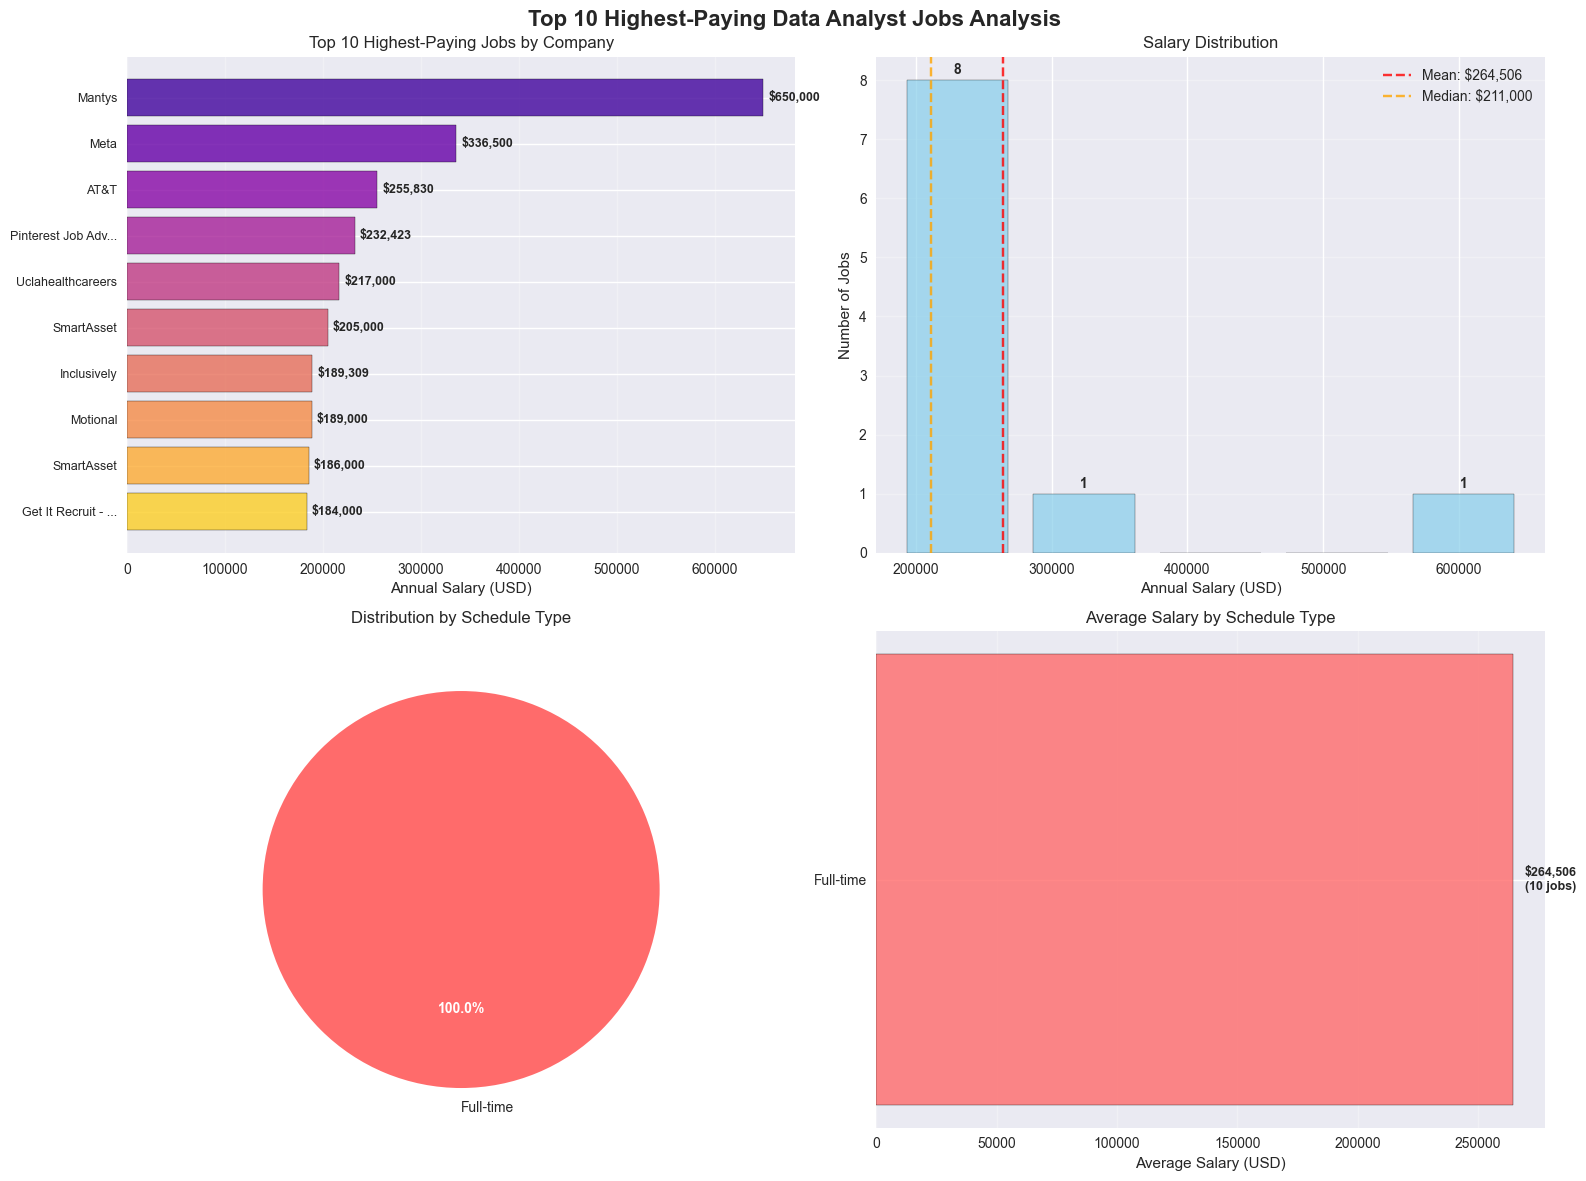

=== DETAILED INSIGHTS ===
üè¢ Company Analysis:
  ‚Ä¢ AT&T: 1 job(s), Max: $255,830
  ‚Ä¢ Get It Recruit - Information Technology: 1 job(s), Max: $184,000
  ‚Ä¢ Inclusively: 1 job(s), Max: $189,309
  ‚Ä¢ Mantys: 1 job(s), Max: $650,000
  ‚Ä¢ Meta: 1 job(s), Max: $336,500
  ‚Ä¢ Motional: 1 job(s), Max: $189,000
  ‚Ä¢ Pinterest Job Advertisements: 1 job(s), Max: $232,423
  ‚Ä¢ SmartAsset: 2 job(s), Max: $205,000
  ‚Ä¢ Uclahealthcareers: 1 job(s), Max: $217,000

üìä Salary Gaps Between Consecutive Ranks:
  ‚Ä¢ Rank 1 vs 2: $313,500 difference (48.2% gap)
  ‚Ä¢ Rank 2 vs 3: $80,670 difference (24.0% gap)
  ‚Ä¢ Rank 3 vs 4: $23,406 difference (9.1% gap)
  ‚Ä¢ Rank 4 vs 5: $15,423 difference (6.6% gap)
  ‚Ä¢ Rank 5 vs 6: $12,000 difference (5.5% gap)
  ‚Ä¢ Rank 6 vs 7: $15,691 difference (7.7% gap)
  ‚Ä¢ Rank 7 vs 8: $309 difference (0.2% gap)
  ‚Ä¢ Rank 8 vs 9: $3,000 difference (1.6% gap)
  ‚Ä¢ Rank 9 vs 10: $2,000 difference (1.1% gap)

üìÖ Job Posting Timeline:
  ‚Ä¢ 2023-01: 2 job(s)

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import psycopg2
from sqlalchemy import create_engine
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# =============================================================================
# POSTGRESQL DATABASE CONNECTION
# =============================================================================

def load_top_paying_data_analyst_jobs():
    """
    Load top 10 highest-paying Data Analyst jobs that are available remotely.
    Focuses on job postings with specified salaries (removes nulls).
    """
    
    # Your SQL query for top paying Data Analyst jobs
    sql_query = """
    SELECT 
        job_id,
        job_title,
        job_location,
        job_schedule_type,
        salary_year_avg,
        job_posted_date,
        name AS company_name
    FROM
        job_postings_fact
    LEFT JOIN 
        company_dim ON job_postings_fact.company_id = company_dim.company_id
    WHERE
        job_title_short = 'Data Analyst' AND
        job_location = 'Anywhere' AND
        salary_year_avg IS NOT NULL
    ORDER BY
        salary_year_avg DESC
    LIMIT 10
    """
    
    # Database connection parameters
    DB_CONFIG = {
        'host': 'localhost',
        'port': 5432,
        'database': 'sql_course',
        'username': 'postgres',
        'password': 'fauzanrmds'
    }
    
    # Create connection string
    CONNECTION_STRING = f"postgresql://{DB_CONFIG['username']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
    
    print("Connecting to PostgreSQL database...")
    print(f"Host: {DB_CONFIG['host']}:{DB_CONFIG['port']}")
    print(f"Database: {DB_CONFIG['database']}")
    print(f"User: {DB_CONFIG['username']}")
    
    try:
        # Create database engine
        engine = create_engine(CONNECTION_STRING)
        
        # Test connection
        with engine.connect() as conn:
            print("‚úÖ Database connection successful!")
        
        # Execute query and load into DataFrame
        print("Executing SQL query...")
        df = pd.read_sql_query(sql_query, engine)
        
        if df.empty:
            raise ValueError("Query returned no results. Check your data and query conditions.")
        
        print(f"‚úÖ Successfully loaded {len(df)} top-paying jobs from database")
        return df
        
    except Exception as e:
        print(f"‚ùå Database operation failed: {str(e)}")
        print("\nüí° Troubleshooting tips:")
        print("1. Check if PostgreSQL is running")
        print("2. Verify database name, username, and password")
        print("3. Ensure the required tables exist: job_postings_fact, company_dim")
        print("4. Check if your user has SELECT permissions on these tables")
        raise

# =============================================================================
# LOAD AND ANALYZE DATA
# =============================================================================

print("=== TOP 10 HIGHEST-PAYING DATA ANALYST JOBS ===\n")

# Load data from PostgreSQL database
df = load_top_paying_data_analyst_jobs()

# Data preprocessing
df['salary_year_avg'] = df['salary_year_avg'].astype(float)
df['salary_formatted'] = df['salary_year_avg'].apply(lambda x: f"${x:,.0f}")
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['posting_month'] = df['job_posted_date'].dt.strftime('%Y-%m')
df['posting_year'] = df['job_posted_date'].dt.year

print(f"Analysis Focus: Top 10 highest-paying remote Data Analyst positions")
print(f"Salary range: ${df['salary_year_avg'].min():,.0f} - ${df['salary_year_avg'].max():,.0f}")
print(f"Date range: {df['job_posted_date'].min().strftime('%Y-%m-%d')} to {df['job_posted_date'].max().strftime('%Y-%m-%d')}\n")

# Display the top 10 jobs
print("=== TOP 10 HIGHEST-PAYING DATA ANALYST JOBS ===")
for i, (_, row) in enumerate(df.iterrows(), 1):
    posted_date = row['job_posted_date'].strftime('%Y-%m-%d')
    print(f"{i}. {row['job_title']}")
    print(f"   Company: {row['company_name']}")
    print(f"   Salary: ${row['salary_year_avg']:,.0f}")
    print(f"   Schedule: {row['job_schedule_type']}")
    print(f"   Posted: {posted_date}")
    print()

print("=" * 70 + "\n")

# Calculate salary statistics
print("=== SALARY ANALYSIS ===")
salary_stats = df['salary_year_avg'].describe()
print(f"üí∞ Salary Statistics:")
print(f"  ‚Ä¢ Highest Salary: ${salary_stats['max']:,.0f}")
print(f"  ‚Ä¢ Lowest Salary: ${salary_stats['min']:,.0f}")
print(f"  ‚Ä¢ Average Salary: ${salary_stats['mean']:,.0f}")
print(f"  ‚Ä¢ Median Salary: ${salary_stats['50%']:,.0f}")
print(f"  ‚Ä¢ Standard Deviation: ${salary_stats['std']:,.0f}")
print(f"  ‚Ä¢ Salary Range: ${salary_stats['max'] - salary_stats['min']:,.0f}")

print("\n" + "=" * 70 + "\n")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Top 10 Highest-Paying Data Analyst Jobs Analysis', fontsize=16, fontweight='bold')

# 1. Horizontal Bar Chart - Top 10 Jobs by Salary
ax1 = axes[0, 0]
colors1 = plt.cm.plasma(np.linspace(0.1, 0.9, len(df)))
bars1 = ax1.barh(range(len(df)), df['salary_year_avg'], color=colors1, edgecolor='black', alpha=0.8)
ax1.set_yticks(range(len(df)))

# Create shortened company names for better display
company_labels = []
for _, row in df.iterrows():
    if len(row['company_name']) > 20:
        label = row['company_name'][:17] + "..."
    else:
        label = row['company_name']
    company_labels.append(label)

ax1.set_yticklabels(company_labels, fontsize=9)
ax1.set_xlabel('Annual Salary (USD)')
ax1.set_title('Top 10 Highest-Paying Jobs by Company')
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()  # Highest salary at top

# Add salary labels on bars
for i, (bar, salary) in enumerate(zip(bars1, df['salary_year_avg'])):
    ax1.text(bar.get_width() + 5000, bar.get_y() + bar.get_height()/2, 
             f'${salary:,.0f}', va='center', fontweight='bold', fontsize=9)

# 2. Salary Distribution Histogram
ax2 = axes[0, 1]
n_bins = 5
counts, bins, patches = ax2.hist(df['salary_year_avg'], bins=n_bins, color='skyblue', 
                                edgecolor='black', alpha=0.7, rwidth=0.8)
ax2.set_xlabel('Annual Salary (USD)')
ax2.set_ylabel('Number of Jobs')
ax2.set_title('Salary Distribution')
ax2.grid(axis='y', alpha=0.3)

# Add count labels on histogram bars
for count, bin_edge, patch in zip(counts, bins[:-1], patches):
    if count > 0:
        ax2.text(patch.get_x() + patch.get_width()/2, patch.get_height() + 0.05, 
                f'{int(count)}', ha='center', va='bottom', fontweight='bold')

# Add statistics lines
mean_salary = df['salary_year_avg'].mean()
median_salary = df['salary_year_avg'].median()
ax2.axvline(mean_salary, color='red', linestyle='--', alpha=0.8, 
           label=f'Mean: ${mean_salary:,.0f}')
ax2.axvline(median_salary, color='orange', linestyle='--', alpha=0.8, 
           label=f'Median: ${median_salary:,.0f}')
ax2.legend()

# 3. Jobs by Schedule Type
ax3 = axes[1, 0]
schedule_counts = df['job_schedule_type'].value_counts()
colors3 = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'][:len(schedule_counts)]

# Create pie chart
wedges, texts, autotexts = ax3.pie(schedule_counts.values, labels=schedule_counts.index, 
                                   autopct='%1.1f%%', colors=colors3, startangle=90,
                                   explode=[0.05] * len(schedule_counts))
ax3.set_title('Distribution by Schedule Type')

# Enhance pie chart text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

# 4. Average Salary by Schedule Type
ax4 = axes[1, 1]
schedule_salary = df.groupby('job_schedule_type')['salary_year_avg'].agg(['mean', 'count']).reset_index()
schedule_salary = schedule_salary.sort_values('mean', ascending=True)

bars4 = ax4.barh(range(len(schedule_salary)), schedule_salary['mean'], 
                color=colors3[:len(schedule_salary)], edgecolor='black', alpha=0.8)
ax4.set_yticks(range(len(schedule_salary)))
ax4.set_yticklabels(schedule_salary['job_schedule_type'])
ax4.set_xlabel('Average Salary (USD)')
ax4.set_title('Average Salary by Schedule Type')
ax4.grid(axis='x', alpha=0.3)

# Add salary labels and job counts
for i, (bar, avg_salary, job_count) in enumerate(zip(bars4, schedule_salary['mean'], schedule_salary['count'])):
    ax4.text(bar.get_width() + 5000, bar.get_y() + bar.get_height()/2, 
             f'${avg_salary:,.0f}\n({int(job_count)} jobs)', va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

# Additional Analysis
print("=== DETAILED INSIGHTS ===")

# Company analysis
company_analysis = df.groupby('company_name').agg({
    'salary_year_avg': ['count', 'mean', 'max'],
    'job_title': 'first'
}).round(0)
company_analysis.columns = ['job_count', 'avg_salary', 'max_salary', 'sample_title']

print(f"üè¢ Company Analysis:")
for company, row in company_analysis.iterrows():
    print(f"  ‚Ä¢ {company}: {int(row['job_count'])} job(s), Max: ${int(row['max_salary']):,}")

# Salary gaps analysis
df_sorted = df.sort_values('salary_year_avg', ascending=False).reset_index(drop=True)
print(f"\nüìä Salary Gaps Between Consecutive Ranks:")
for i in range(len(df_sorted)-1):
    current_company = df_sorted.loc[i, 'company_name']
    next_company = df_sorted.loc[i+1, 'company_name']
    current_salary = df_sorted.loc[i, 'salary_year_avg']
    next_salary = df_sorted.loc[i+1, 'salary_year_avg']
    gap = current_salary - next_salary
    gap_percentage = (gap / current_salary * 100)
    print(f"  ‚Ä¢ Rank {i+1} vs {i+2}: ${gap:,.0f} difference ({gap_percentage:.1f}% gap)")

# Posting timeline analysis
posting_analysis = df.groupby('posting_month').size().sort_index()
print(f"\nüìÖ Job Posting Timeline:")
for month, count in posting_analysis.items():
    print(f"  ‚Ä¢ {month}: {count} job(s)")

# Title analysis
title_words = []
for title in df['job_title']:
    words = title.lower().split()
    title_words.extend(words)

# Count common words (excluding common stop words)
stop_words = {'data', 'analyst', 'the', 'and', 'or', 'in', 'at', 'for', 'with', 'by', 'of', 'to', 'a', 'an'}
word_counts = {}
for word in title_words:
    clean_word = word.strip('(),.-/')
    if clean_word not in stop_words and len(clean_word) > 2:
        word_counts[clean_word] = word_counts.get(clean_word, 0) + 1

# Sort by frequency
sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
print(f"\nüî§ Most Common Words in Job Titles (excluding 'Data Analyst'):")
for word, count in sorted_words[:8]:
    print(f"  ‚Ä¢ '{word.title()}': appears {count} time(s)")

# Performance metrics
top_performer = df.iloc[0]
print(f"\nüèÜ Top Performer:")
print(f"  ‚Ä¢ Position: {top_performer['job_title']}")
print(f"  ‚Ä¢ Company: {top_performer['company_name']}")
print(f"  ‚Ä¢ Salary: ${top_performer['salary_year_avg']:,.0f}")
print(f"  ‚Ä¢ Premium over average: {((top_performer['salary_year_avg'] - df['salary_year_avg'].mean()) / df['salary_year_avg'].mean() * 100):+.1f}%")

# Create summary DataFrame for export
summary_df = df.copy()
summary_df['rank'] = range(1, len(summary_df) + 1)
summary_df['salary_premium_vs_avg'] = ((summary_df['salary_year_avg'] - summary_df['salary_year_avg'].mean()) 
                                      / summary_df['salary_year_avg'].mean() * 100).round(1)
summary_df = summary_df[['rank', 'job_title', 'company_name', 'salary_year_avg', 'salary_premium_vs_avg', 
                        'job_schedule_type', 'job_posted_date']]

print(f"\n‚úÖ Analysis complete! Top 10 highest-paying remote Data Analyst opportunities identified.")
print(f"üíº Average salary of top 10 jobs: ${df['salary_year_avg'].mean():,.0f}")
print(f"üìà Salary range spread: ${((df['salary_year_avg'].max() - df['salary_year_avg'].min()) / df['salary_year_avg'].min() * 100):.1f}%")

=== TOP SKILLS BASED ON SALARY FOR DATA ANALYSTS ===

Connecting to PostgreSQL database...
Host: localhost:5432
Database: sql_course
User: postgres
‚úÖ Database connection successful!
Executing SQL query...
‚úÖ Successfully loaded 25 skills from database
Analysis Focus: Data Analyst positions with specified salaries (all locations)
Average salary range: $115,480 - $400,000
Total skills analyzed: 25

=== TOP 10 HIGHEST-PAYING SKILLS FOR DATA ANALYSTS ===
1. Svn: $400,000
2. Solidity: $179,000
3. Couchbase: $160,515
4. Datarobot: $155,486
5. Golang: $155,000
6. Mxnet: $149,000
7. Dplyr: $147,633
8. Vmware: $147,500
9. Terraform: $146,734
10. Twilio: $138,500


=== TOP 5 MOST FINANCIALLY REWARDING SKILLS ===
1. Svn: $400,000 (+176.1% vs average)
2. Solidity: $179,000 (+23.5% vs average)
3. Couchbase: $160,515 (+10.8% vs average)
4. Datarobot: $155,486 (+7.3% vs average)
5. Golang: $155,000 (+7.0% vs average)

Overall average salary across all skills: $144,890




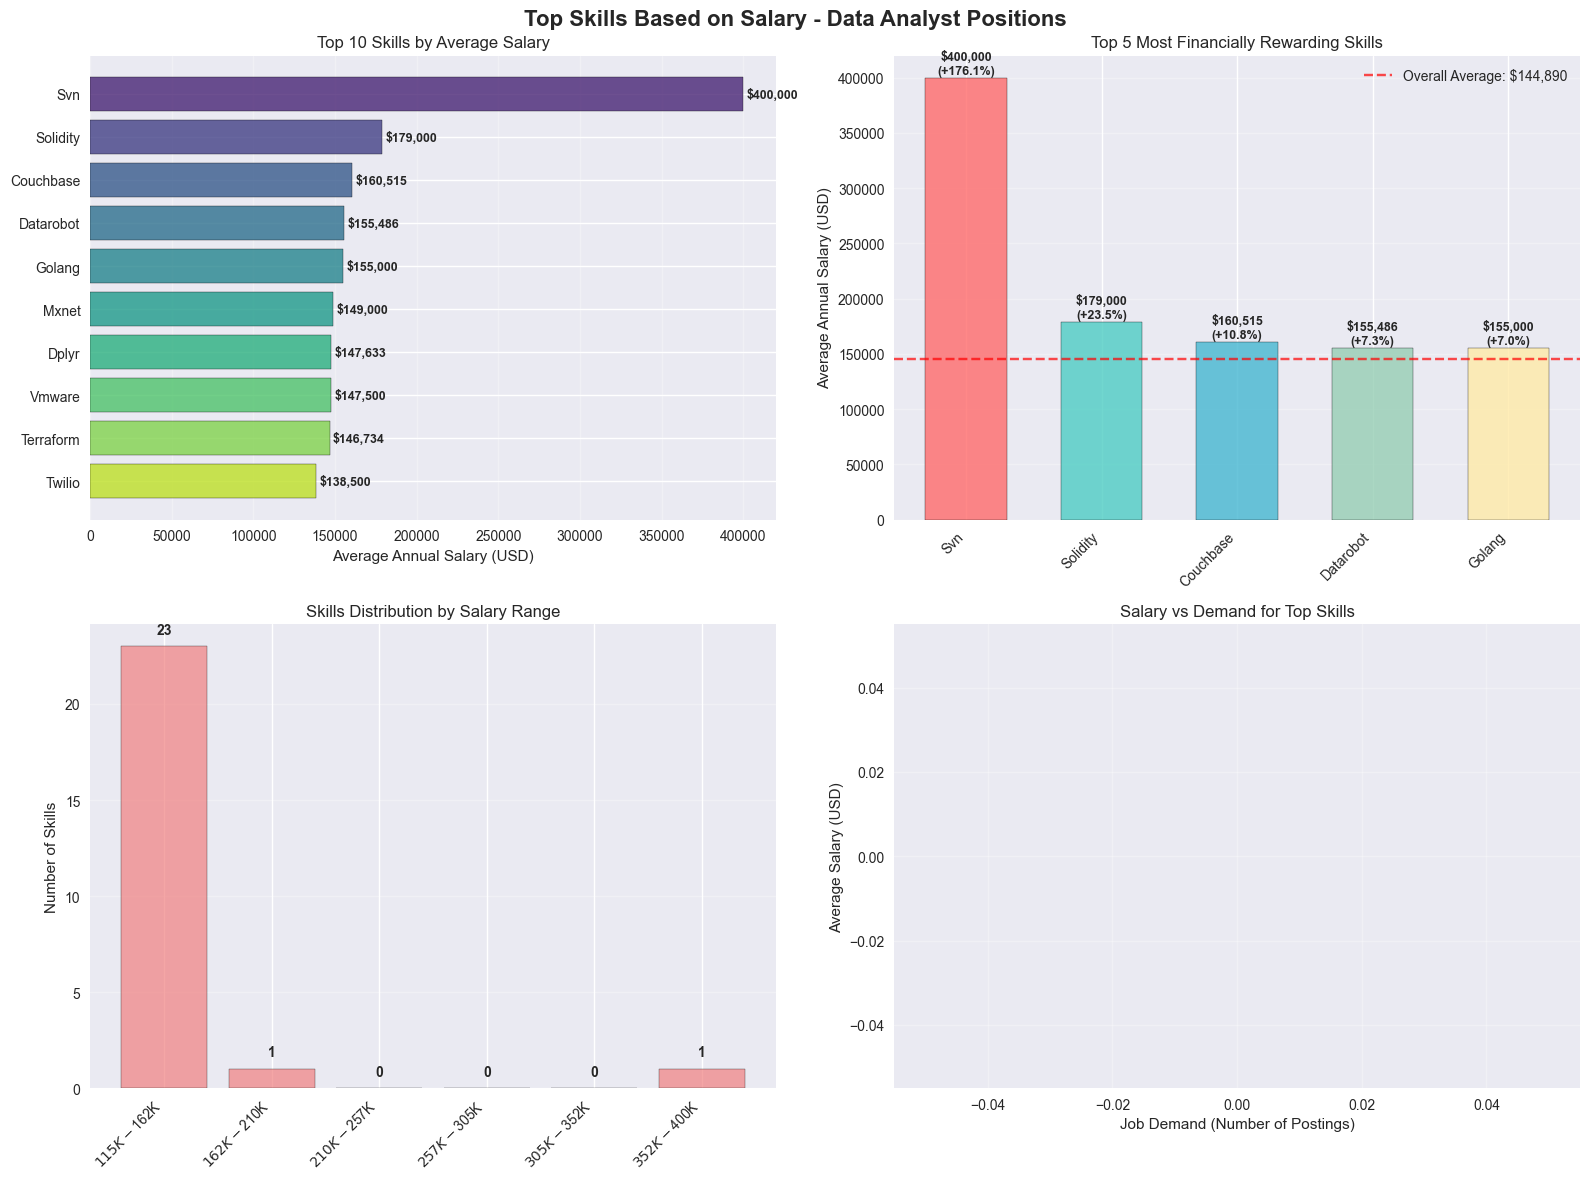

=== DETAILED SALARY IMPACT ANALYSIS ===
üí∞ Salary Statistics Across All Skills:
  ‚Ä¢ Highest Average: $400,000
  ‚Ä¢ Lowest Average: $115,480
  ‚Ä¢ Overall Mean: $144,890
  ‚Ä¢ Median: $129,820
  ‚Ä¢ Standard Deviation: $55,723

üìà Salary Premium Analysis (Top 10 Skills):
  1. Svn: +176.1% premium ($+255,110)
  2. Solidity: +23.5% premium ($+34,110)
  3. Couchbase: +10.8% premium ($+15,625)
  4. Datarobot: +7.3% premium ($+10,596)
  5. Golang: +7.0% premium ($+10,110)
  6. Mxnet: +2.8% premium ($+4,110)
  7. Dplyr: +1.9% premium ($+2,743)
  8. Vmware: +1.8% premium ($+2,610)
  9. Terraform: +1.3% premium ($+1,844)
  10. Twilio: -4.4% premium ($-6,390)

üìã Skills by Category (Top 15):
  ‚Ä¢ Specialized/Other (Avg: $161,703):
    - Svn: $400,000
    - Solidity: $179,000
    - Couchbase: $160,515
    - Datarobot: $155,486
    - Golang: $155,000
    - Mxnet: $149,000
    - Dplyr: $147,633
    - Vmware: $147,500
    - Terraform: $146,734
    - Twilio: $138,500
    - Gitlab: $134,126


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import psycopg2
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# =============================================================================
# POSTGRESQL DATABASE CONNECTION
# =============================================================================

def load_top_skills_by_salary():
    """
    Load top skills based on average salary for Data Analyst positions.
    Focuses on roles with specified salaries, regardless of location.
    Reveals how different skills impact salary levels for Data Analysts.
    """
    
    # Your SQL query for top skills by average salary
    sql_query = """
    SELECT
        skills,
        ROUND(AVG(salary_year_avg), 0) AS avg_salary
    FROM
        job_postings_fact
    INNER JOIN
        skills_job_dim ON job_postings_fact.job_id = skills_job_dim.job_id
    INNER JOIN
        skills_dim ON skills_job_dim.skill_id = skills_dim.skill_id
    WHERE
        job_title_short = 'Data Analyst' 
        --AND job_work_from_home = TRUE
        AND salary_year_avg IS NOT NULL
    GROUP BY
        skills
    ORDER BY   
        avg_salary DESC
    LIMIT 25
    """
    
    # Database connection parameters
    DB_CONFIG = {
        'host': 'localhost',
        'port': 5432,
        'database': 'sql_course',
        'username': 'postgres',
        'password': 'fauzanrmds'
    }
    
    # Create connection string
    CONNECTION_STRING = f"postgresql://{DB_CONFIG['username']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
    
    print("Connecting to PostgreSQL database...")
    print(f"Host: {DB_CONFIG['host']}:{DB_CONFIG['port']}")
    print(f"Database: {DB_CONFIG['database']}")
    print(f"User: {DB_CONFIG['username']}")
    
    try:
        # Create database engine
        engine = create_engine(CONNECTION_STRING)
        
        # Test connection
        with engine.connect() as conn:
            print("‚úÖ Database connection successful!")
        
        # Execute query and load into DataFrame
        print("Executing SQL query...")
        df = pd.read_sql_query(sql_query, engine)
        
        if df.empty:
            raise ValueError("Query returned no results. Check your data and query conditions.")
        
        print(f"‚úÖ Successfully loaded {len(df)} skills from database")
        return df
        
    except Exception as e:
        print(f"‚ùå Database operation failed: {str(e)}")
        print("\nüí° Troubleshooting tips:")
        print("1. Check if PostgreSQL is running")
        print("2. Verify database name, username, and password")
        print("3. Ensure the required tables exist: job_postings_fact, skills_job_dim, skills_dim")
        print("4. Check if your user has SELECT permissions on these tables")
        raise

def get_skill_demand_data():
    """
    Get additional data about skill demand (job count) to complement salary analysis.
    """
    sql_query = """
    SELECT
        skills,
        COUNT(job_postings_fact.job_id) AS demand_count,
        ROUND(AVG(salary_year_avg), 0) AS avg_salary
    FROM
        job_postings_fact
    INNER JOIN
        skills_job_dim ON job_postings_fact.job_id = skills_job_dim.job_id
    INNER JOIN
        skills_dim ON skills_job_dim.skill_id = skills_dim.skill_id
    WHERE
        job_title_short = 'Data Analyst' 
        AND salary_year_avg IS NOT NULL
    GROUP BY
        skills
    HAVING
        COUNT(job_postings_fact.job_id) >= 10  -- Filter for skills with meaningful sample size
    ORDER BY   
        avg_salary DESC
    """
    
    # Database connection parameters
    DB_CONFIG = {
        'host': 'localhost',
        'port': 5432,
        'database': 'sql_course',
        'username': 'postgres',
        'password': 'fauzanrmds'
    }
    
    CONNECTION_STRING = f"postgresql://{DB_CONFIG['username']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
    
    try:
        engine = create_engine(CONNECTION_STRING)
        df = pd.read_sql_query(sql_query, engine)
        return df
    except Exception as e:
        print(f"Warning: Could not load demand data: {str(e)}")
        return None

# =============================================================================
# LOAD AND ANALYZE DATA
# =============================================================================

print("=== TOP SKILLS BASED ON SALARY FOR DATA ANALYSTS ===\n")

# Load main data from PostgreSQL database
df = load_top_skills_by_salary()

# Load additional demand data for context
demand_df = get_skill_demand_data()

# Data preprocessing
df['skills'] = df['skills'].str.title()  # Capitalize for better presentation
df['avg_salary'] = df['avg_salary'].astype(float)
df['salary_formatted'] = df['avg_salary'].apply(lambda x: f"${x:,.0f}")

print(f"Analysis Focus: Data Analyst positions with specified salaries (all locations)")
print(f"Average salary range: ${df['avg_salary'].min():,.0f} - ${df['avg_salary'].max():,.0f}")
print(f"Total skills analyzed: {len(df)}\n")

# Display the top 10 skills by salary
top_10_skills = df.head(10)
print("=== TOP 10 HIGHEST-PAYING SKILLS FOR DATA ANALYSTS ===")
for i, (_, row) in enumerate(top_10_skills.iterrows(), 1):
    print(f"{i}. {row['skills']}: ${row['avg_salary']:,.0f}")

print("\n" + "=" * 70 + "\n")

# Display the top 5 skills (as per original query limit)
top_5_skills = df.head(5)
print("=== TOP 5 MOST FINANCIALLY REWARDING SKILLS ===")
for i, (_, row) in enumerate(top_5_skills.iterrows(), 1):
    overall_avg = df['avg_salary'].mean()
    premium = ((row['avg_salary'] - overall_avg) / overall_avg * 100)
    print(f"{i}. {row['skills']}: ${row['avg_salary']:,.0f} ({premium:+.1f}% vs average)")

print(f"\nOverall average salary across all skills: ${df['avg_salary'].mean():,.0f}")
print("\n" + "=" * 70 + "\n")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Top Skills Based on Salary - Data Analyst Positions', fontsize=16, fontweight='bold')

# 1. Top 10 Skills by Average Salary - Horizontal Bar Chart
ax1 = axes[0, 0]
colors1 = plt.cm.viridis(np.linspace(0.1, 0.9, len(top_10_skills)))
bars1 = ax1.barh(range(len(top_10_skills)), top_10_skills['avg_salary'], 
                 color=colors1, edgecolor='black', alpha=0.8)
ax1.set_yticks(range(len(top_10_skills)))
ax1.set_yticklabels(top_10_skills['skills'], fontsize=10)
ax1.set_xlabel('Average Annual Salary (USD)')
ax1.set_title('Top 10 Skills by Average Salary')
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()  # Highest salary at top

# Add salary labels on bars
for i, (bar, salary) in enumerate(zip(bars1, top_10_skills['avg_salary'])):
    ax1.text(bar.get_width() + 2000, bar.get_y() + bar.get_height()/2, 
             f'${salary:,.0f}', va='center', fontweight='bold', fontsize=9)

# 2. Top 5 Skills - Vertical Bar Chart with Premium Analysis
ax2 = axes[0, 1]
colors2 = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
bars2 = ax2.bar(range(len(top_5_skills)), top_5_skills['avg_salary'], 
                color=colors2, edgecolor='black', alpha=0.8, width=0.6)
ax2.set_xticks(range(len(top_5_skills)))
ax2.set_xticklabels(top_5_skills['skills'], rotation=45, ha='right')
ax2.set_ylabel('Average Annual Salary (USD)')
ax2.set_title('Top 5 Most Financially Rewarding Skills')
ax2.grid(axis='y', alpha=0.3)

# Add overall average line
overall_avg = df['avg_salary'].mean()
ax2.axhline(overall_avg, color='red', linestyle='--', alpha=0.7, 
           label=f'Overall Average: ${overall_avg:,.0f}')

# Add salary labels and premium percentages
for i, (bar, row) in enumerate(zip(bars2, top_5_skills.iterrows())):
    salary = row[1]['avg_salary']
    premium = ((salary - overall_avg) / overall_avg * 100)
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000, 
             f'${salary:,.0f}\n({premium:+.1f}%)', ha='center', va='bottom', 
             fontweight='bold', fontsize=9)

ax2.legend()

# 3. Salary Distribution Analysis
ax3 = axes[1, 0]
# Create salary ranges for analysis
salary_ranges = pd.cut(df['avg_salary'], bins=6, precision=0)
range_counts = salary_ranges.value_counts().sort_index()

# Convert intervals to strings for better labels
range_labels = [f"${int(interval.left/1000)}K-${int(interval.right/1000)}K" 
                for interval in range_counts.index]

bars3 = ax3.bar(range(len(range_counts)), range_counts.values, 
                color='lightcoral', edgecolor='black', alpha=0.7)
ax3.set_xticks(range(len(range_counts)))
ax3.set_xticklabels(range_labels, rotation=45, ha='right')
ax3.set_ylabel('Number of Skills')
ax3.set_title('Skills Distribution by Salary Range')
ax3.grid(axis='y', alpha=0.3)

# Add count labels
for bar, count in zip(bars3, range_counts.values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{count}', ha='center', va='bottom', fontweight='bold')

# 4. Skills vs Demand Analysis (if demand data available)
ax4 = axes[1, 1]
if demand_df is not None and not demand_df.empty:
    # Merge with demand data for top skills
    demand_df['skills'] = demand_df['skills'].str.title()
    top_skills_with_demand = pd.merge(top_10_skills, demand_df[['skills', 'demand_count']], 
                                     on='skills', how='left')
    
    # Create scatter plot
    scatter = ax4.scatter(top_skills_with_demand['demand_count'], 
                         top_skills_with_demand['avg_salary'],
                         c=colors1[:len(top_skills_with_demand)], 
                         s=100, alpha=0.7, edgecolors='black')
    
    ax4.set_xlabel('Job Demand (Number of Postings)')
    ax4.set_ylabel('Average Salary (USD)')
    ax4.set_title('Salary vs Demand for Top Skills')
    ax4.grid(True, alpha=0.3)
    
    # Add skill labels
    for i, row in top_skills_with_demand.iterrows():
        if pd.notna(row['demand_count']):
            ax4.annotate(row['skills'], 
                        (row['demand_count'], row['avg_salary']),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8, alpha=0.8)
else:
    # Fallback: Show salary comparison with baseline
    baseline_skills = ['Sql', 'Excel', 'Python', 'Tableau', 'Power Bi']
    baseline_data = df[df['skills'].isin(baseline_skills)].copy()
    
    if not baseline_data.empty:
        bars4 = ax4.bar(range(len(baseline_data)), baseline_data['avg_salary'], 
                       color='lightblue', edgecolor='black', alpha=0.7)
        ax4.set_xticks(range(len(baseline_data)))
        ax4.set_xticklabels(baseline_data['skills'], rotation=45, ha='right')
        ax4.set_ylabel('Average Salary (USD)')
        ax4.set_title('Common Skills - Salary Comparison')
        ax4.grid(axis='y', alpha=0.3)
        
        # Add salary labels
        for bar, salary in zip(bars4, baseline_data['avg_salary']):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000, 
                    f'${salary:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    else:
        ax4.text(0.5, 0.5, 'Demand data not available', ha='center', va='center', 
                transform=ax4.transAxes, fontsize=12)
        ax4.set_title('Salary Analysis')

plt.tight_layout()
plt.show()

# Additional Analysis
print("=== DETAILED SALARY IMPACT ANALYSIS ===")

# Calculate salary statistics
salary_stats = df['avg_salary'].describe()
print(f"üí∞ Salary Statistics Across All Skills:")
print(f"  ‚Ä¢ Highest Average: ${salary_stats['max']:,.0f}")
print(f"  ‚Ä¢ Lowest Average: ${salary_stats['min']:,.0f}")
print(f"  ‚Ä¢ Overall Mean: ${salary_stats['mean']:,.0f}")
print(f"  ‚Ä¢ Median: ${salary_stats['50%']:,.0f}")
print(f"  ‚Ä¢ Standard Deviation: ${salary_stats['std']:,.0f}")

# Premium analysis for top skills
print(f"\nüìà Salary Premium Analysis (Top 10 Skills):")
overall_mean = df['avg_salary'].mean()
for i, (_, row) in enumerate(top_10_skills.iterrows(), 1):
    premium = ((row['avg_salary'] - overall_mean) / overall_mean * 100)
    premium_amount = row['avg_salary'] - overall_mean
    print(f"  {i}. {row['skills']}: {premium:+.1f}% premium (${premium_amount:+,.0f})")

# Skill categories analysis
skill_categories = {
    'Sql': 'Database Management',
    'Python': 'Programming Language',
    'R': 'Statistical Programming',
    'Excel': 'Spreadsheet Analysis',
    'Tableau': 'Data Visualization',
    'Power Bi': 'Business Intelligence',
    'Aws': 'Cloud Computing',
    'Azure': 'Cloud Computing',
    'Spark': 'Big Data Processing',
    'Hadoop': 'Big Data Processing',
    'Snowflake': 'Data Warehouse',
    'Oracle': 'Database Management',
    'Sas': 'Statistical Software',
    'Spss': 'Statistical Software'
}

print(f"\nüìã Skills by Category (Top 15):")
categorized_skills = {}
top_15_skills = df.head(15)

for _, row in top_15_skills.iterrows():
    skill = row['skills']
    category = skill_categories.get(skill, 'Specialized/Other')
    if category not in categorized_skills:
        categorized_skills[category] = []
    categorized_skills[category].append((skill, row['avg_salary']))

for category, skill_list in categorized_skills.items():
    avg_category_salary = np.mean([salary for _, salary in skill_list])
    print(f"  ‚Ä¢ {category} (Avg: ${avg_category_salary:,.0f}):")
    for skill, salary in skill_list:
        print(f"    - {skill}: ${salary:,.0f}")

# ROI Analysis
print(f"\nüí° Key Insights for Skill Development:")
top_3 = top_5_skills.head(3)
print(f"üèÜ Top 3 Most Financially Rewarding Skills:")
for i, (_, row) in enumerate(top_3.iterrows(), 1):
    roi_vs_avg = ((row['avg_salary'] - overall_mean) / overall_mean * 100)
    print(f"  {i}. {row['skills']}: ${row['avg_salary']:,.0f} ({roi_vs_avg:+.1f}% ROI vs average skill)")

# Market positioning
high_value_threshold = df['avg_salary'].quantile(0.8)  # Top 20%
high_value_skills = df[df['avg_salary'] >= high_value_threshold]
print(f"\nüéØ High-Value Skills (Top 20% by salary):")
print(f"  ‚Ä¢ Threshold: ${high_value_threshold:,.0f}")
print(f"  ‚Ä¢ Number of high-value skills: {len(high_value_skills)}")
print(f"  ‚Ä¢ Skills: {', '.join(high_value_skills['skills'].tolist())}")

# Create summary DataFrame for export
summary_df = df.head(15).copy()
summary_df['rank'] = range(1, len(summary_df) + 1)
summary_df['salary_premium_pct'] = ((summary_df['avg_salary'] - overall_mean) / overall_mean * 100).round(1)
summary_df['salary_premium_amount'] = (summary_df['avg_salary'] - overall_mean).round(0)
summary_df['category'] = summary_df['skills'].map(lambda x: skill_categories.get(x, 'Specialized/Other'))

print(f"\n‚úÖ Analysis complete! Skills ranked by financial impact for Data Analysts identified.")
print(f"üéØ Focus on top 5 skills for maximum salary potential: {', '.join(top_5_skills['skills'].tolist())}")
print(f"üìä Average salary increase from top skill vs overall average: ${top_5_skills.iloc[0]['avg_salary'] - overall_mean:,.0f}")